# Multiple infillers

Here we investigate three infillers that perform many cruncher operations. The first one is designed to infill all required data for running openSCM, with the minimum of inputs. One is designed to break down aggregate values, like the Kyoto gases or HFCs. The second does the opposite, recalculating aggregates from its components. These functions are purposefully not as object-oriented as the crunchers so that modellers unfamiliar with this coding structure can use them. 

You will need to install silicone in order to run this code. 

## Imports

In [1]:
import os.path
import traceback

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyam

import silicone.multiple_infillers as mi
from silicone.utils import (
    convert_units_to_MtCO2_equiv,
    get_sr15_scenarios,
    return_cases_which_consistently_split,
)

<IPython.core.display.Javascript object>

In [2]:
SR15_SCENARIOS = "./sr15_scenarios.csv"

## Example data

Here we pull some example data by downloading a selection of the SR1.5 scenarios.

In [3]:
valid_model_ids = [
    "MESSAGE*",
    "AIM*",
    "C-ROADS*",
    "GCAM*",
    "IEA*",
    "IMAGE*",
    "MERGE*",
    "POLES*",
    "REMIND*",
    "WITCH*",
]
if not os.path.isfile(SR15_SCENARIOS):
    get_sr15_scenarios(SR15_SCENARIOS, valid_model_ids)

### Starting point

Our starting point is the test data, loaded as a `pyam.IamDataFrame`.

In [4]:
sr15_data = pyam.IamDataFrame(SR15_SCENARIOS)
target = "Emissions|CO2"
constituents = ["Emissions|CO2|*"]
to_infill = sr15_data.filter(model="WITCH*", variable=[target] + constituents)
database = sr15_data.filter(model="WITCH*", keep=False)
to_infill.head()

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file sr15_scenarios.csv


,model,scenario,region,variable,unit,year,value
0,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CO2,Mt CO2/yr,2005,31922.044350
1,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CO2,Mt CO2/yr,2010,35303.387760
2,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CO2,Mt CO2/yr,2020,37312.307110
3,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CO2,Mt CO2/yr,2030,10560.008460
4,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CO2,Mt CO2/yr,2040,7435.934987


## Investigating where the data is consistent

A utility function called return_cases_which_consistently_split indicates which variables consist of only other variables, which is useful to know in order to work out where data can be consistently split using decompose_collection_with_time_dep_ratio. Note that this is not a requirement for using that method (a consistent aggregate value is constructed in any case) but indicates that this is approach is rigorous. 

In the first instance, it does not find any results because there are several layers of constituents. However with only one layer, this works as expected. Note that if only one layer is used, there is also a pyam built-in function called 'check_consistency' that performs the same effect. 

In [5]:
no_cases = return_cases_which_consistently_split(
    to_infill, target, constituents,
)
len(no_cases)

0

However in the case below, we select only the next level of info, and find it matches in all cases (the number of cases does not depend on the accuracy, as shown in the second box. 

In [6]:
all_cases = return_cases_which_consistently_split(
    to_infill,
    target,
    ["Emissions|CO2|AFOLU", "Emissions|CO2|Energy and Industrial Processes"],
)
len(all_cases)

39

In [7]:
all_cases = return_cases_which_consistently_split(
    to_infill,
    target,
    ["Emissions|CO2|AFOLU", "Emissions|CO2|Energy and Industrial Processes"],
    how_close={
        "equal_nan": True,
        "rtol": 100,  # This means that we accept a factor of 100 inaccuracy.
    },
)
len(all_cases)

39

## Using the infiller functions
Here we show the use of the DecomposeCollectionTimeDepRatio and InfillAllRequiredVariables functions. 
### InfillAllRequiredVariables
This is a function to more conveniently infill all of the required variables that are not already found in the system. 

In [8]:
database.tail()

,model,scenario,region,variable,unit,year,value
144196,MESSAGEix-GLOBIOM 1.0,LowEnergyDemand,World,Emissions|VOC,Mt VOC/yr,2060,73.727451
144197,MESSAGEix-GLOBIOM 1.0,LowEnergyDemand,World,Emissions|VOC,Mt VOC/yr,2070,71.741307
144198,MESSAGEix-GLOBIOM 1.0,LowEnergyDemand,World,Emissions|VOC,Mt VOC/yr,2080,69.745374
144199,MESSAGEix-GLOBIOM 1.0,LowEnergyDemand,World,Emissions|VOC,Mt VOC/yr,2090,67.882569
144200,MESSAGEix-GLOBIOM 1.0,LowEnergyDemand,World,Emissions|VOC,Mt VOC/yr,2100,65.285422


In [9]:
to_infill.tail()

,model,scenario,region,variable,unit,year,value
3385,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr,2060,29487.271577
3386,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr,2070,31404.870008
3387,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr,2080,31911.146283
3388,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr,2090,30995.012917
3389,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr,2100,29852.454850


In [10]:
infilled = mi.infill_all_required_variables(
    to_infill, database, [target], output_timesteps=list(range(2020, 2101, 10))
)
infilled.head()

/Users/znicholls/Documents/AGCEC/Misc/silicone/src/silicone/multiple_infillers/infill_all_required_emissions_for_openscm.py:182: UserWarning: No data for ['Emissions|HFC|HFC245ca'], it will be infilled with 0s
  unavailable_variables
silicone.database_crunchers.constant_ratio - INFO: <class 'silicone.database_crunchers.constant_ratio.ConstantRatio'> won't use any information from the database
Filling required variables:   0%|          | 0/22 [00:00<?, ?it/s]

Note that the lead variable ['Emissions|CO2'] goes negative.


Filling required variables: 100%|██████████| 22/22 [00:04<00:00,  5.13it/s]


,model,scenario,region,variable,unit,year,value
0,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|BC,Mt BC/yr,2020,6.559421
1,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|BC,Mt BC/yr,2030,4.979146
2,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|BC,Mt BC/yr,2040,4.250863
3,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|BC,Mt BC/yr,2050,3.668986
4,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|BC,Mt BC/yr,2060,3.205862


We now have a complete scenario, with all required variables. 

In [11]:
to_infill.filter().variables(True)

,variable,unit
0,Emissions|CO2,Mt CO2/yr
1,Emissions|CO2|AFOLU,Mt CO2/yr
2,Emissions|CO2|Energy and Industrial Processes,Mt CO2/yr
3,Emissions|CO2|Energy|Demand,Mt CO2/yr
4,Emissions|CO2|Energy|Demand|Industry,Mt CO2/yr
5,Emissions|CO2|Energy|Demand|Residential and Co...,Mt CO2/yr
6,Emissions|CO2|Energy|Demand|Transportation,Mt CO2/yr
7,Emissions|CO2|Energy|Supply,Mt CO2/yr
8,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr
9,Emissions|CO2|Energy|Supply|Liquids,Mt CO2/yr


### DecomposeCollectionTimeDepRatio
This function is designed to split up an aggregate value into its known components, using the relationship between these found in models that have all components (but not necessarily the aggregate variable). The aggregate value is calculated in the first step.

In [12]:
database["unit"].unique()

array(['Mt BC/yr', 'Mt CH4/yr', 'Mt CO/yr', 'Mt CO2/yr',
       'Mt CO2-equiv/yr', 'kt HFC134a-equiv/yr', 'kt HFC125/yr',
       'kt HFC134a/yr', 'kt HFC143a/yr', 'kt HFC227ea/yr', 'kt HFC23/yr',
       'kt HFC32/yr', 'kt HFC43-10/yr', 'kt N2O/yr', 'Mt NH3/yr',
       'Mt NO2/yr', 'Mt OC/yr', 'kt CF4-equiv/yr', 'kt SF6/yr',
       'Mt SO2/yr', 'Mt VOC/yr', 'kt HFC245fa/yr', 'kt C2F6/yr',
       'kt C6F14/yr', 'kt CF4/yr'], dtype=object)

In [13]:
# Define some calculation parameters
components = [
    "Emissions|CO2",
    "Emissions|CH4",
    "Emissions|N2O",
    "Emissions|F-Gases",
]
aggregate = "Emissions|Kyoto Gases (AR4-GWP100)"
to_infill = sr15_data.filter(
    model="WITCH*", scenario="SSP1*", variable=aggregate
)
unit_consistent_db = convert_units_to_MtCO2_equiv(
    database.filter(variable=components)
)
unit_consistent_db.variables(True)

,variable,unit
0,Emissions|CH4,Mt CO2-equiv/yr
1,Emissions|CO2,Mt CO2/yr
2,Emissions|F-Gases,Mt CO2-equiv/yr
3,Emissions|N2O,Mt CO2-equiv/yr


In [14]:
to_infill.variables(True)

,variable,unit
0,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr


In [15]:
decomposer = mi.DecomposeCollectionTimeDepRatio(unit_consistent_db)
results = decomposer.infill_components(
    aggregate, components, to_infill, only_consistent_cases=False
)
decomposer_all = mi.DecomposeCollectionTimeDepRatio(unit_consistent_db)
results_all = decomposer.infill_components(aggregate, components, to_infill)
results.head()

silicone.database_crunchers.time_dep_ratio - WARNING: Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.
silicone.database_crunchers.time_dep_ratio - WARNING: Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.


Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.
Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.


silicone.database_crunchers.time_dep_ratio - WARNING: Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.
silicone.database_crunchers.time_dep_ratio - WARNING: Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.


Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.
Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.


silicone.database_crunchers.time_dep_ratio - WARNING: Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.
silicone.database_crunchers.time_dep_ratio - WARNING: Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.


Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.
Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.


silicone.database_crunchers.time_dep_ratio - WARNING: Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.
silicone.database_crunchers.time_dep_ratio - WARNING: Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.


Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.
Note that the lead variable ['Emissions|Kyoto Gases (AR4-GWP100)'] goes negative. The time dependent ratio cruncher can produce unexpected results in this case.


,model,scenario,region,variable,unit,year,value
0,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CO2-equiv/yr,2005,8895.197906
1,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CO2-equiv/yr,2010,9572.564123
2,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CO2-equiv/yr,2015,9631.421497
3,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CO2-equiv/yr,2020,9442.434266
4,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CO2-equiv/yr,2030,3398.896989


Text(0.5, 1.0, 'CO2 calculated as a fraction of Kyoto gas, with (solid) and without (dashed) model/scenario data not reported at some times')

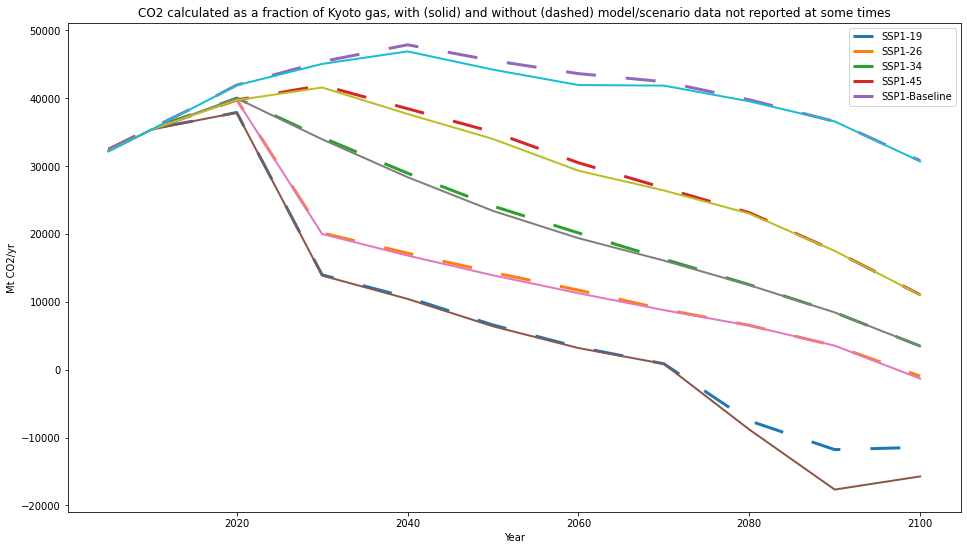

In [16]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
results.filter(variable="*CO2").plot(
    ax=ax, linestyle="--", dashes=(10, 10), linewidth=3
)
results_all.filter(variable="*CO2").plot(ax=ax, linewidth=2)
plt.title(
    "CO2 calculated as a fraction of Kyoto gas, with (solid) and without (dashed) model/scenario data not reported at some times"
)

In [17]:
# We now have variable information for each of the components
results.variable

['Emissions|CH4', 'Emissions|CO2', 'Emissions|F-Gases', 'Emissions|N2O']

### SplitCollectionWithRemainderEmissions
This technique is also used for splitting up an aggregated basket of emissions, however does not assume that the emissions are in proportion to the aggregate at any given time. The key advantage of this is that it allows some emissions that are naturally limited to stay within their limits. The key disadvantage is that one of the emissions is only determined by conservation of the aggregate, and therefore may have quite a non-representative value. It is best for situations where one of the emissions is either very large compared to the others, or of unknown sign. This technique can be used with any cruncher, however the default is QRW. In most cases, CO$_2$ will be the emission to use as the 'remainder'. We will apply this technique to the same case as above, although we will not convert the units to be the same this time as the function will do this automatically. Note that this requires unit conversion to make the values comparable. In this case, we specify that the values be converted to CO$_2$-equivalent with AR4 GWP100 values, using the `metric_name` option. 

In [18]:
components = [
    "Emissions|CH4",
    "Emissions|N2O",
    "Emissions|F-Gases",
]
remainder = (
    "Emissions|CO2"  # This is the component that will make up the difference
)
aggregate = "Emissions|Kyoto Gases (AR4-GWP100)"
to_infill = sr15_data.filter(
    model="WITCH*", scenario="SSP1*", variable=aggregate
)
all_rem_vars = [remainder, aggregate] + components

In [19]:
split_remainder = mi.SplitCollectionWithRemainderEmissions(
    database.filter(variable=all_rem_vars)
)
remainder_split_res = split_remainder.infill_components(
    aggregate, components, remainder, to_infill, metric_name="AR4GWP100",
)
remainder_split_res.head()

,model,scenario,region,variable,unit,year,value
0,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CH4/yr,2005,318.943537
1,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CH4/yr,2010,349.436770
2,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CH4/yr,2015,347.646810
3,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CH4/yr,2020,334.279689
4,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CH4/yr,2030,199.041328


We can compare this infilling method with that of the DecomposeCollectionTimeDepRatio method above. We plot them below, with the DecomposeCollection method dashed. 

<AxesSubplot:title={'center':'model: WITCH-GLOBIOM 3.1 - region: World - variable: Emissions|CH4'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

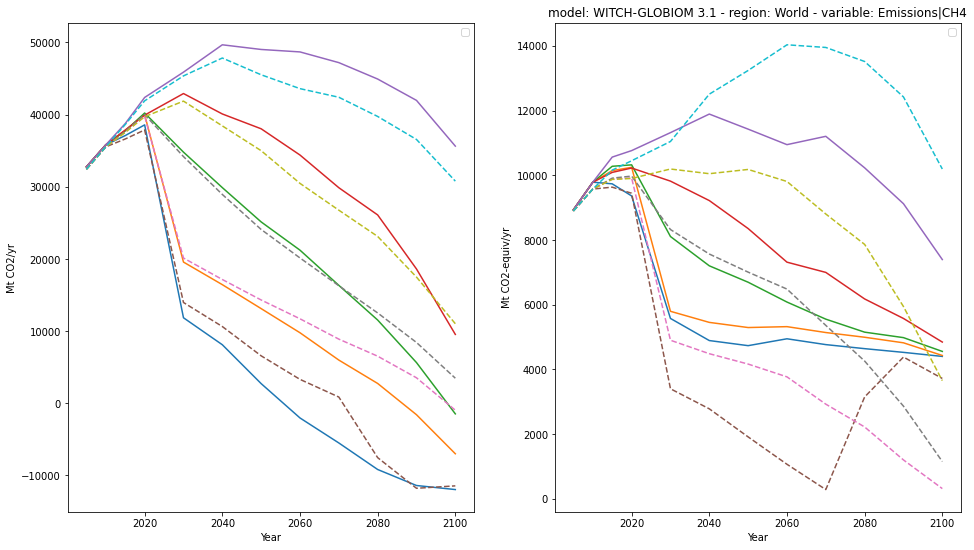

In [20]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
remainder_split_res.filter(variable="*CO2").plot(ax=ax, label="__")
results.filter(variable="*CO2").plot(ax=ax, linestyle="--", label="__")
plt.title("")
ax = fig.add_subplot(122)
convert_units_to_MtCO2_equiv(
    remainder_split_res.filter(variable="*CH4")
).plot(ax=ax, label="__")
results.filter(variable="*CH4").plot(ax=ax, linestyle="--", label="__")

We see that the results are fairly similar for CO$_2$, since they make up the bulk of the aggregate in both cases. However the CH$_4$ results are very different, as they can take any positive value in the ratio-based technique, whereas it is constrained to keep to values in the infiller database in the QRW-based SplitCollection technique. This particularly results in regular behaviour when the lead values go negative, as seen in the lowermost curve on the right after 2070 - the methane level increases as the lead value becomes more negative for the DecomposeCollection method, whereas the (more expected) results from the SplitCollection method is a slow decline in emissions. 

### Calculate aggregate values
This tool is used to build an aggregate value that ensures that the data is self-consistent. In our case, the database has a value for F-Gases, but these aggregates are not consistent with the AR5 conversion factors. We want the AR5 values, which are the default, so do not add a `metric_name` value this time. 

In [21]:
to_infill = sr15_data.filter(model="WITCH*")
target = "Emissions|F-Gases"
components = ["Emissions|HFC", "Emissions|PFC", "Emissions|SF6"]
valid_cases = return_cases_which_consistently_split(
    to_infill, target, components, how_close={"equal_nan": True, "rtol": 0.1,},
)
len(valid_cases)

0

We first convert them to a common unit.

In [22]:
to_infill = to_infill.filter(variable=[target] + components)
to_infill = convert_units_to_MtCO2_equiv(to_infill)
to_infill.filter(variable=target, scenario="ADVANCE_2020_Med2C").head()

,model,scenario,region,variable,unit,year,value
0,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2005,717.000054
1,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2010,948.020176
2,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2015,609.746591
3,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2020,800.446286
4,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2025,351.541200


The recalculated values are similar but noticably different:

In [23]:
infilled = mi.infill_composite_values(to_infill, {target: components})
infilled.filter(variable=target, scenario="ADVANCE_2020_Med2C").head()

,model,scenario,region,variable,unit,year,value
0,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2005,610.958880
1,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2010,949.847085
2,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2015,567.248506
3,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2020,828.263273
4,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2025,307.759959


We have now fixed the inconsistency problem:

In [24]:
to_infill.filter(variable=target, keep=False, inplace=True)
to_infill.append(infilled, inplace=True)
valid_cases = return_cases_which_consistently_split(
    to_infill,
    target,
    components,
    metric_name="AR4GWP100",
    how_close={"equal_nan": True, "rtol": 0.01,},
)
len(valid_cases)

9

In [25]:
len(to_infill.scenario)

9

The `infill_composite_values` function can also take a dictionary of dictionaries as its second argument if the values should be multiplied by constants before summing them. This allows us to subtract values as well. 

In [26]:
aggregate = "Emissions|CO2|Other"
other_CO2 = mi.infill_composite_values(
    sr15_data,
    {
        aggregate: {
            "Emissions|CO2": 1,
            "Emissions|CO2|Energy and Industrial Processes": -1,
            "Emissions|CO2|AFOLU": -1,
        }
    },
)

In [27]:
other_CO2.head(10)

,model,scenario,region,variable,unit,year,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2005,85.2526
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2010,89.6442
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2015,75.3558
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2020,78.3179
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2025,27.3933
5,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2030,20.0998
6,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2035,17.3219
7,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2040,15.2576
8,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2045,13.5058
9,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2050,13.4414


These values are relatively small (cf. 34000 total emissions), so presumably represent rounding errors. 